In [253]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from time import time
import numpy as np
import warnings
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
import functools
import math
import pickle
from sklearn.externals import joblib
import csv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [254]:
movies_df = pd.read_csv('joined_movies_w_factors_and_genomes.csv')

In [7]:
# descriptive
print(movies_df.columns.values[0:100])
print(movies_df.dtypes)
movies_df

['title_script' 'genre_script' 'filename' 'title_p' 'movieId' 'title'
 'genres' 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X11' 'X12'
 'X13' 'X14' 'X15' 'X16' 'X17' 'X18' 'X19' 'X20' 'X21' 'X22' 'X23' 'X24'
 'X25' 'X26' 'X27' 'X28' 'X29' 'X30' 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7'
 'G8' 'G9' 'G10' 'G11' 'G12' 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19'
 'G20' 'G21' 'G22' 'G23' 'G24' 'G25' 'G26' 'G27' 'G28' 'G29' 'G30' 'G31'
 'G32' 'G33' 'G34' 'G35' 'G36' 'G37' 'G38' 'G39' 'G40' 'G41' 'G42' 'G43'
 'G44' 'G45' 'G46' 'G47' 'G48' 'G49' 'G50' 'G51' 'G52' 'G53' 'G54' 'G55'
 'G56' 'G57' 'G58' 'G59' 'G60' 'G61' 'G62' 'G63']
title_script     object
genre_script     object
filename         object
title_p          object
movieId           int64
title            object
genres           object
X1              float64
X2              float64
X3              float64
X4              float64
X5              float64
X6              float64
X7              float64
X8              float64
X9          

,title_script,genre_script,filename,title_p,movieId,title,genres,X1,X2,X3,...,G1121,G1122,G1123,G1124,G1125,G1126,G1127,G1128,center,scale
0,10 Things I Hate About You,"Comedy,Romance",10ThingsIHateAboutYou.txt,10 things i hate about you,2572,10 Things I Hate About You (1999),Comedy|Romance,-0.016455,0.018789,-0.013277,...,0.02275,0.01975,0.26425,0.09425,0.01425,0.01475,0.08425,0.01900,3.422841,0.838362
1,12 Years a Slave,Drama,12YearsaSlave.txt,12 years a slave,105844,12 Years a Slave (2013),Drama,0.008645,0.003144,0.001322,...,0.08550,0.06875,0.16950,0.11200,0.02500,0.05175,0.09950,0.02600,3.969348,0.785555
2,127 Hours,"Adventure,Drama,Thriller",127Hours.txt,127 hours,81562,127 Hours (2010),Adventure|Drama|Thriller,0.012059,-0.001237,-0.005137,...,0.01625,0.11225,0.16725,0.10250,0.02800,0.01700,0.18200,0.03775,3.778436,0.769731
3,1492: Conquest of Paradise,"Adventure,Drama",1492ConquestofParadise.txt,1492: conquest of paradise,8905,1492: Conquest of Paradise (1992),Adventure|Drama,-0.001974,-0.005688,-0.007619,...,0.02200,0.02625,0.21350,0.05575,0.02325,0.02800,0.07675,0.01575,3.266966,0.798400
4,15 Minutes,"Action,Crime,Thriller",15Minutes.txt,15 minutes,4167,15 Minutes (2001),Thriller,-0.011999,-0.005283,-0.017477,...,0.01225,0.03300,0.33225,0.04800,0.02475,0.01300,0.10300,0.01825,3.048880,0.863857
5,17 Again,"Comedy,Drama,Romance",17Again.txt,17 again,68135,17 Again (2009),Comedy|Drama,-0.009621,0.009796,0.000850,...,0.01575,0.01975,0.23350,0.05800,0.01500,0.00725,0.05775,0.01350,3.071837,0.877974
6,187,Drama,187.txt,187,1609,187 (One Eight Seven) (1997),Drama|Thriller,-0.004879,-0.009280,-0.012055,...,0.00975,0.05325,0.23750,0.08475,0.02025,0.00900,0.07475,0.01625,3.037685,0.805997
7,2001: A Space Odyssey,"Adventure,Sci-Fi",2001ASpaceOdyssey.txt,2001: a space odyssey,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,0.040611,-0.009755,0.003340,...,0.02225,0.07375,0.16975,0.10350,0.08850,0.01375,0.05700,0.01875,3.982353,1.032352
8,2012,"Action,Adventure,Drama,Sci-Fi,Thriller",2012.txt,2012,72378,2012 (2009),Action|Drama|Sci-Fi|Thriller,-0.021496,0.002300,0.003894,...,0.01825,0.01425,0.26750,0.08300,0.02050,0.01175,0.10775,0.01800,2.738335,1.051909
9,25th Hour,"Crime,Drama",25thHour.txt,25th hour,5954,25th Hour (2002),Crime|Drama,0.020300,-0.008028,-0.020965,...,0.01925,0.17400,0.33475,0.21325,0.03325,0.01850,0.06600,0.02000,3.891669,0.782572


For some reason there are still movies without scripts and movies with NA's (check why the NAs are there!!!). Remove them here.

In [255]:
#Missing file names
movies_df = movies_df[pd.notnull(movies_df["filename"])]
#Remove pdfs
movies_df = movies_df[movies_df["filename"].str.contains(r"\.txt$")]
#Manually remove these two since the scripts are missing
movies_df = movies_df[(movies_df["filename"] != "Apollo13.txt") & (movies_df["filename"] != "ScaryMovie2.txt")]
#NaN factors
movies_df = movies_df[pd.notnull(movies_df["X1"])]
#by removing movies with NaN genome, we are remove some movies (over a dozen)
#that would be good for regressing against factors X1
movies_df = movies_df[pd.notnull(movies_df["G1"])]
movies_df.reset_index(inplace=True,drop=True)

In [256]:
script_files = ('raw/' + movies_df.filename).tolist()

Some stuff on CountVectorizer from the documentation:

"Convert a collection of text documents to a matrix of token counts"

Makes everything lowercase by default.

Default tokenizer: "The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)."

Can use a built-in stop word list for English.

It cannot be parallelized, but you can use HashingVectorizer instead, which has some limitations (can't figure out what words are associated with each feature?). CountVectorizer is fast enough for our ~800 scripts.

In [257]:
# We want to do some stemming before building the bag-of-words.
# We do this by building a new class that inherits from CountVectorizer.
## This is the simplest thing to do, as it allows us to use all the nice
## features from CountVectorizer (preprocessing to remove uppercase and 
## punctuation, decent tokenizing, stop words) and just add the stemming
## step, rather than having to rewrite everything.

class StemmedCountVectorizer(CountVectorizer):
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedCountVectorizer,self).__init__(*args, **kwargs)
        self.stemmer = stemmer
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer,self).build_analyzer()
        return lambda doc:[self.stemmer.stem(w) for w in analyzer(doc)]
    
class LemmaCountVectorizer(CountVectorizer):
    def __init__(self, *args, **kwargs):
        super(LemmaCountVectorizer,self).__init__(*args, **kwargs)
        self.wnl = WordNetLemmatizer()
        
    #the lemmatizer always needs a part of speech
    #use pos_tag to get the part of speech and then lemmatize
    #memoize this since pos_tag is very sloow
    @functools.lru_cache(maxsize=100000)
    def pos_tag_and_lemmatize(self,word):
        pos_tag = nltk.pos_tag([word])
        pos = get_wordnet_pos(pos_tag[0][1])
        return self.wnl.lemmatize(word,pos)
    
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer,self).build_analyzer()
        return lambda doc:[self.pos_tag_and_lemmatize(w) for w in analyzer(doc)]

#The parts of speech returned by pos_tag do not match the ones
#from wordnet. Convert them.
#This could probably be a lot more efficient.
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [258]:
#vectorizer = StemmedCountVectorizer(input='filename',decode_error='ignore',stop_words='english', max_features=10000, stemmer=PorterStemmer())
vectorizer = LemmaCountVectorizer(input='filename',decode_error='ignore',stop_words='english', max_features=10000)

In [259]:
start = time()
features = vectorizer.fit_transform(script_files)
print(time()-start)

38.87812519073486


In [13]:
print(vectorizer.vocabulary_["great"])
print(movies_df.ix[484]["title"])
#great is 3993
#movie 484 is man on the moon
print(features[484,4033])
#we can verify that man of the moon has 17 "great"s

4033
Man on the Moon (1999)
18


I should try to do PCA before cutting off features?

In [260]:
def random_forest_grid_search(target, features):
    forest = RandomForestRegressor(n_jobs=-1)
    
    n_features = features.get_shape()[1]
    max_features = [math.floor(math.sqrt(n_features)),n_features//3]
    if n_features < 4000:
        max_features.append(n_features)

    param_grid = {"max_features": max_features,
                  "max_depth": [None],
                  "n_estimators": [200,500,1000]}

    #3-fold by default
    grid_search = GridSearchCV(forest,param_grid=param_grid)
    start = time()
    grid_search.fit(features,target)
    elapsed = time() - start
    print("Time to fit: %f" % elapsed)
    return grid_search

def print_importances(rf_model,n = 25):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1] #[::-1] just reverses
    
    print("Feature ranking:")
    for f in range(25):
        print("%d. %s (%f)" % (f+1,vectorizer.get_feature_names()[indices[f]], importances[indices[f]]))

def elastic_net_grid_search(target, features):
    elastic = ElasticNet(normalize=True)

    param_grid_el = {"l1_ratio": [0.0,0.1,0.3,0.5,0.7,0.9,1.0],
                     "alpha": [1,1e-1,1e-2,1e-3,1e-4,1e-5]}

    grid_search_el = GridSearchCV(elastic,param_grid=param_grid_el,cv=10,n_jobs=36)
    start = time()
    # We will often get a warning that the fit did not converge,
    # because many of the grid values may be bad
    with warnings.catch_warnings():
        grid_search_el.fit(features,target)
    print(time() - start)
    return grid_search_el

# First run a random forest regression over all features
# to find the N most important features.
## Then run both elastic net and random forest fits using only
## the smaller subset of N features. The smaller random forest
## fits will be the best predictors. The elastic net fits are used
## to distinguish between "positive" features (which predict large or
## positve target) and "negative" features (small/negative target).
### From experimentation (though only with one particular target),
### it seems like 20-100 are decent values for N (they produce the best
### scores on the limited feature fits). 100 was the best, but 20 and 50
### were also decent. 10 and 200 were significantly worse.
#### This returns (the large random forest grid, the feature names
####               sorted by importance of the best large random forest,
####               an array of smaller random forest grids (one for each value of N),
####               an array of smaller elastic net grids)
def elastic_forest(target):
    rf_grid_all = random_forest_grid_search(target, features)

    importances = rf_grid_all.best_estimator_.feature_importances_
    ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses
    feature_names = [vectorizer.get_feature_names()[i] for i in ordered_indices]
    
    rf_grids = []
    en_grids = []
    for n_features in [20,50,100,200]:
        rf_grids.append(random_forest_grid_search(target,features[:,ordered_indices[0:n_features]]))
        en_grids.append(elastic_net_grid_search(target, features[:,ordered_indices[0:n_features]]))
    
    return (rf_grid_all,feature_names,rf_grids,en_grids)

In [261]:
# In sklearn 0.18, there is a bug that prevents pickling of GridSearchCV
# objects. This is because they used masked numpy arrays, which pickle
# does not handle. Make a work around to convert all masked arrays to
# unmasked, before pickling

def process_GridSearchCV_pickling(grid_search_obj):
    for k,v in grid_search_obj.cv_results_.items():
        if not k.startswith("param_"):
            continue
        #convert masked array to array
        grid_search_obj.cv_results_[k] = np.array(v)

def process_fit_object_pickling(fit_object):
    process_GridSearchCV_pickling(fit_object[0])
    for fit in fit_object[2]:
        process_GridSearchCV_pickling(fit)
    for fit in fit_object[3]:
        process_GridSearchCV_pickling(fit)

In [202]:
targets = ["X" + str(i) for i in range(1,31)]
fits = []

for target in targets:
    fit = elastic_forest(movies_df[target])
    fits.append(fit)
    process_fit_object_pickling(fit)
    with open("saved_objects/"+target+"_fit.pickle","wb") as handle:
        pickle.dump(fit,handle)

Time to fit: 132.481373
Time to fit: 33.944545


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.965200424194336
Time to fit: 36.045017


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.57268214225769
Time to fit: 43.071728


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.302023649215698
Time to fit: 52.645965


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.750561475753784
Time to fit: 166.901403
Time to fit: 33.968788


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.8117921352386475
Time to fit: 36.660228


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.3942108154296875
Time to fit: 39.766639


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.7918860912323
Time to fit: 50.180485


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.648083925247192
Time to fit: 164.972018
Time to fit: 33.648510


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.047393798828125
Time to fit: 36.255175


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.923379898071289
Time to fit: 40.015681


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.801710844039917
Time to fit: 48.209578


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.753012657165527
Time to fit: 169.229095
Time to fit: 33.871829


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.3753268718719482
Time to fit: 35.693853


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.665545225143433
Time to fit: 38.988154


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.44160532951355
Time to fit: 48.717215


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.01030158996582
Time to fit: 163.285257
Time to fit: 33.992999


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.7792530059814453
Time to fit: 36.617081


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.39176869392395
Time to fit: 41.307092


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.1477744579315186
Time to fit: 49.092726


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.632347345352173
Time to fit: 166.795065
Time to fit: 34.696622


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.7891101837158203
Time to fit: 36.308908


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.594707489013672
Time to fit: 40.684244


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.63538122177124
Time to fit: 50.433769


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.976791858673096
Time to fit: 173.086008
Time to fit: 33.666641


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.235093355178833
Time to fit: 36.143388


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.570142984390259
Time to fit: 40.222696


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.272998094558716
Time to fit: 50.594764


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.367082118988037
Time to fit: 137.556674
Time to fit: 35.306126


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.92213773727417
Time to fit: 36.333967


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.9291818141937256
Time to fit: 40.287953


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.8195741176605225
Time to fit: 48.956184


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.2268455028533936
Time to fit: 163.142853
Time to fit: 34.125449


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.305375814437866
Time to fit: 36.302415


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.926406621932983
Time to fit: 41.965139


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.582420349121094
Time to fit: 51.229451


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.174509286880493
Time to fit: 171.892294
Time to fit: 35.141844


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.58577823638916
Time to fit: 36.227467


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.592371225357056
Time to fit: 40.931667


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.129943132400513
Time to fit: 48.859094


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.6268837451934814
Time to fit: 142.280212
Time to fit: 34.389919


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.2629194259643555
Time to fit: 35.579769


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.047544479370117
Time to fit: 40.848853


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.372151613235474
Time to fit: 49.084095


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.610031604766846
Time to fit: 143.664566
Time to fit: 34.236911


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.743485927581787
Time to fit: 35.904835


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.10262656211853
Time to fit: 40.335015


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.324843883514404
Time to fit: 49.956256


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.958817958831787
Time to fit: 150.908542
Time to fit: 34.144618


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.9987142086029053
Time to fit: 35.487854


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.076630353927612
Time to fit: 37.966264


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.578816652297974
Time to fit: 46.812518


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.393959999084473
Time to fit: 146.720013
Time to fit: 35.965712


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.413961887359619
Time to fit: 36.509477


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.40538763999939
Time to fit: 39.372834


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.181260824203491
Time to fit: 46.921040


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.136174201965332
Time to fit: 184.520492
Time to fit: 35.048197


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.022858619689941
Time to fit: 35.119277


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.084462881088257
Time to fit: 39.744777


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.194812297821045
Time to fit: 47.504577


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.603810787200928
Time to fit: 149.173083
Time to fit: 34.982185


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.101527452468872
Time to fit: 36.891185


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.875368356704712
Time to fit: 38.884626


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.7656941413879395
Time to fit: 48.199598


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.798396110534668
Time to fit: 147.711211
Time to fit: 36.472385


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.2509050369262695
Time to fit: 34.646009


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.537571907043457
Time to fit: 38.170139


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.032147169113159
Time to fit: 46.081455


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.054062366485596
Time to fit: 150.420447
Time to fit: 35.809802


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.277218580245972
Time to fit: 35.805144


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.595914840698242
Time to fit: 39.642075


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.98696231842041
Time to fit: 46.325172


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.773846864700317
Time to fit: 149.673959
Time to fit: 36.535837


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.126932144165039
Time to fit: 35.547240


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.36067008972168
Time to fit: 38.835897


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.8157312870025635
Time to fit: 48.950000


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.573309421539307
Time to fit: 150.412050
Time to fit: 36.121977


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.0300681591033936
Time to fit: 37.339778


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.056040287017822
Time to fit: 40.102563


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.06744384765625
Time to fit: 49.020044


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.6776978969573975
Time to fit: 152.429628
Time to fit: 37.470926


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.150971174240112
Time to fit: 37.404301


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.898300409317017
Time to fit: 39.085017


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.209636688232422
Time to fit: 47.933859


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.554651975631714
Time to fit: 149.118021
Time to fit: 34.857137


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.828526258468628
Time to fit: 36.173934


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.342412948608398
Time to fit: 42.359088


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.636430501937866
Time to fit: 50.384926


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.518308877944946
Time to fit: 151.998490
Time to fit: 35.720341


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.787076473236084
Time to fit: 36.355680


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.159632921218872
Time to fit: 38.069854


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.539409399032593
Time to fit: 44.810998


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

7.057375907897949
Time to fit: 149.398730
Time to fit: 36.753170


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.7648773193359375
Time to fit: 36.256008


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.129049777984619
Time to fit: 37.934438


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.19144606590271
Time to fit: 46.199888


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.6426122188568115
Time to fit: 154.979432
Time to fit: 36.607529


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.167256593704224
Time to fit: 34.382760


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.23547101020813
Time to fit: 36.840465


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.0873425006866455
Time to fit: 46.128786


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.3587706089019775
Time to fit: 154.621219
Time to fit: 36.399882


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.2722084522247314
Time to fit: 36.999030


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.194028854370117
Time to fit: 40.817683


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.557756423950195
Time to fit: 48.402262


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

7.066127777099609
Time to fit: 153.022705
Time to fit: 36.196380


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.361308574676514
Time to fit: 36.243174


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.783015012741089
Time to fit: 39.737413


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.770892143249512
Time to fit: 49.269581


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

7.299370527267456
Time to fit: 155.286352
Time to fit: 39.467535


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.384961128234863
Time to fit: 35.026690


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.773104906082153
Time to fit: 39.949047


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.143044948577881
Time to fit: 45.241604


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

7.521857261657715
Time to fit: 155.078556
Time to fit: 36.735702


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.445797920227051
Time to fit: 35.768129


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.635039567947388
Time to fit: 37.835978


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.2950310707092285
Time to fit: 46.466584


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.753246307373047
Time to fit: 161.658774
Time to fit: 36.233830


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.111780405044556
Time to fit: 35.545765


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.747350454330444
Time to fit: 39.538661


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.1384117603302
Time to fit: 47.350177


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.58144211769104


In [257]:
for i in range(30):
    factor_num = i+1
    fit = fits[i]
    best_rf = max(fit[2], key = lambda x: x.best_score_)
    best_en = max(fit[3], key = lambda x: x.best_score_)
    if best_rf.best_score_ < best_en.best_score_:
        print("For factor "+str(factor_num))
        print("Elastic net did better than random forest.")
        print("Elastic net score: "+str(best_en.best_score_))
        print("Random forest score: "+str(best_rf.best_score_))
    # I stupidly forgot to save the indices used so we will have to rederive
    # them here.
    n_features = len(best_rf.best_estimator_.feature_importances_)
    importances = fit[0].best_estimator_.feature_importances_
    ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses
    #Since we are going to use these predictions for making more predictions(!)
    #and we want to evaluate the second-order predictions, we don't
    #want to train on the data we are predicting.
    #So we use cross-validation again (since we foolishly didn't save the
    #results the first time around)
    #This invovles refitting, but only with the smaller model
    target_name = "X%d" % factor_num
    new_column_name = "X%d_cvpred" % factor_num
    predictions = cross_val_predict(best_rf.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    movies_df[target_name],
                                    cv=20, n_jobs=best_rf.n_jobs)
    movies_df[new_column_name] = predictions


For factor 19
Elastic net did better than random forest.
Elastic net score: 0.207987481373
Random forest score: 0.179868971565
For factor 25
Elastic net did better than random forest.
Elastic net score: 0.0702653423966
Random forest score: 0.0447781281619


In [260]:
movies_df.to_csv("joined_movies_w_predictions.csv",index=False, quoting=csv.QUOTE_NONNUMERIC)

Before I forgot to run fits for the scale and center parameters for each movie. Do this below:

In [16]:
targets = ["center","scale"]
fits_second_try = []

for target in targets:
    fit = elastic_forest(movies_df[target])
    fits_second_try.append(fit)
    process_fit_object_pickling(fit)
    with open("saved_objects/"+target+"_fit.pickle","wb") as handle:
        pickle.dump(fit,handle)

Time to fit: 176.149652
Time to fit: 32.604100


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

1.8737609386444092
Time to fit: 36.148759


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

2.4310662746429443
Time to fit: 43.368312


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.867990016937256
Time to fit: 54.370099


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.675068378448486
Time to fit: 175.918117
Time to fit: 34.462888


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

2.2944424152374268
Time to fit: 37.035723


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

2.919393539428711
Time to fit: 41.660189


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.546140432357788
Time to fit: 54.494604


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

6.511730909347534


In [59]:
#Reopen the file we wrote earlier and add the two more columns of predictions and true values.
to_fix_up = pd.read_csv("joined_movies_w_predictions.csv")
for i in range(2):
    fit = fits_second_try[i]
    best_rf = max(fit[2], key = lambda x: x.best_score_)
    best_en = max(fit[3], key = lambda x: x.best_score_)
    if best_rf.best_score_ < best_en.best_score_:
        print("For factor "+str(factor_num))
        print("Elastic net did better than random forest.")
        print("Elastic net score: "+str(best_en.best_score_))
        print("Random forest score: "+str(best_rf.best_score_))
    # I stupidly forgot to save the indices used so we will have to rederive
    # them here.
    n_features = len(best_rf.best_estimator_.feature_importances_)
    importances = fit[0].best_estimator_.feature_importances_
    ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses
    #Since we are going to use these predictions for making more predictions(!)
    #and we want to evaluate the second-order predictions, we don't
    #want to train on the data we are predicting.
    #So we use cross-validation again (since we foolishly didn't save the
    #results the first time around)
    #This invovles refitting, but only with the smaller model
    target_name = targets[i]
    new_column_name = target_name + "_cvpred"
    predictions = cross_val_predict(best_rf.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    movies_df[target_name],
                                    cv=3, n_jobs=best_rf.n_jobs)
    to_fix_up[new_column_name] = predictions
    to_fix_up[target_name] = movies_df[target_name]

For target center
Elastic net did better than random forest.
Elastic net score: 0.321204175706
Random forest score: 0.291924374955


In [68]:
to_fix_up.to_csv("joined_movies_w_predictions.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

In [57]:
fits_second_try[1][2][1].best_score_
sorted(dict(zip(fits_second_try[1][1][0:50],fits_second_try[1][3][1].best_estimator_.coef_)).items(),key =lambda x: -x[1])

[('crotch', 0.0033721332111613764),
 ('cult', 0.0015733063932855242),
 ('sexy', 0.0014916768961915395),
 ('horror', 0.0014292300300174504),
 ('mommy', 0.0012544808547933655),
 ('mai', 0.0011153561438834001),
 ('chick', 0.0010402820053989922),
 ('scream', 0.00073202915946797749),
 ('mask', 0.00064137501574483178),
 ('suck', 0.00047657303632755543),
 ('body', 0.00025894434552825563),
 ('capt', 0.00024655724446063495),
 ('hot', 0.00018041134267047349),
 ('day', -0.0),
 ('chat', 0.0),
 ('mr', -0.0),
 ('tell', -0.0),
 ('hit', 0.0),
 ('look', -0.0),
 ('sit', -0.0),
 ('year', -0.0),
 ('do', -0.0),
 ('walk', -0.0),
 ('hair', 0.0),
 ('think', -0.0),
 ('carry', -0.0),
 ('table', -0.0),
 ('god', 0.0),
 ('watch', -0.0),
 ('away', -0.0),
 ('dante', 0.0),
 ('organ', 0.0),
 ('go', -6.6079664098422876e-06),
 ('turn', -6.8225821987775106e-05),
 ('outside', -0.00011101001512641265),
 ('paper', -0.00011394767722783491),
 ('document', -0.00012411014460686132),
 ('men', -0.00013436523392980666),
 ('nod', -

Do some fits to whether or not a movie fits into a certain genre:

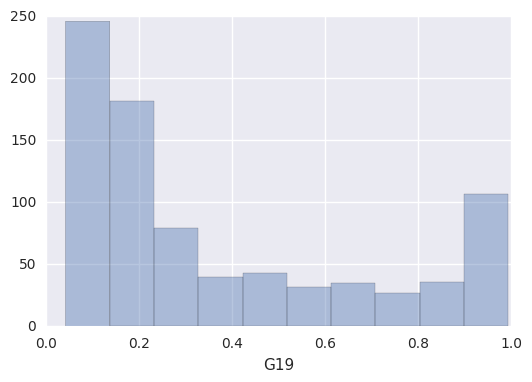

In [24]:
#19 is action, 230 is comedy
sns.distplot(movies_df["G19"],kde=False)
#sns.distplot(movies_df["G230"],kde=False)

In [28]:
#We'll declare anything with comedy/action score > .9 to belong to that genre.
is_comedy = movies_df["G230"] > .9
is_action = movies_df["G19"] > .9

False    721
True     106
Name: G19, dtype: int64

In [70]:
#Rewrite the elastic net/random forest stuff for categorical variables
def random_forest_grid_search_categoric(target, features):
    forest = RandomForestClassifier(n_jobs=-1)
    
    n_features = features.get_shape()[1]
    max_features = [math.floor(math.sqrt(n_features)),n_features//3]
    if n_features < 4000:
        max_features.append(n_features)

    param_grid = {"max_features": max_features,
                  "n_estimators": [200,500,1000]}

    #3-fold by default
    grid_search = GridSearchCV(forest,param_grid=param_grid)
    start = time()
    grid_search.fit(features,target)
    elapsed = time() - start
    print("Time to fit: %f" % elapsed)
    return grid_search

def elastic_net_grid_search_categoric(target, features):
    #elastic = ElasticNet(normalize=True)
    #This doesn't seem to be normalized :(
    elastic = SGDClassifier(loss="log",penalty="elasticnet")

    param_grid_el = {"l1_ratio": [0.0,0.1,0.3,0.5,0.7,0.9,1.0],
                     "alpha": [10000,1000,100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5]}

    grid_search_el = GridSearchCV(elastic,param_grid=param_grid_el,cv=10,n_jobs=36)
    start = time()
    # We will often get a warning that the fit did not converge,
    # because many of the grid values may be bad
    with warnings.catch_warnings():
        grid_search_el.fit(features,target)
    print(time() - start)
    return grid_search_el

# First run a random forest regression over all features
# to find the N most important features.
## Then run both elastic net and random forest fits using only
## the smaller subset of N features. The smaller random forest
## fits will be the best predictors. The elastic net fits are used
## to distinguish between "positive" features (which predict large or
## positve target) and "negative" features (small/negative target).
### From experimentation (though only with one particular target),
### it seems like 20-100 are decent values for N (they produce the best
### scores on the limited feature fits). 100 was the best, but 20 and 50
### were also decent. 10 and 200 were significantly worse.
#### This returns (the large random forest grid, the feature names
####               sorted by importance of the best large random forest,
####               an array of smaller random forest grids (one for each value of N),
####               an array of smaller elastic net grids)
def elastic_forest_categoric(target):
    rf_grid_all = random_forest_grid_search_categoric(target, features)

    importances = rf_grid_all.best_estimator_.feature_importances_
    ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses
    feature_names = [vectorizer.get_feature_names()[i] for i in ordered_indices]
    
    rf_grids = []
    en_grids = []
    for n_features in [20,50,100,200]:
        rf_grids.append(random_forest_grid_search_categoric(target,features[:,ordered_indices[0:n_features]]))
        en_grids.append(elastic_net_grid_search_categoric(target, features[:,ordered_indices[0:n_features]]))
    
    return (rf_grid_all,feature_names,rf_grids,en_grids)

In [71]:
comedy_fits = elastic_forest_categoric(is_comedy)
action_fits = elastic_forest_categoric(is_action)

Time to fit: 51.936868
Time to fit: 47.620916
2.298231601715088
Time to fit: 46.913553
2.318227767944336
Time to fit: 44.523830
2.273993968963623
Time to fit: 45.124579
2.4982848167419434


In [149]:
#Pickling again:
targets = ["comedy","action"]
fits_genres = [comedy_fits,action_fits]

for i,fit in enumerate(fits_genres):
    process_fit_object_pickling(fit)
    with open("saved_objects/"+targets[i]+"_fit.pickle","wb") as handle:
        pickle.dump(fit,handle)

In [240]:
comedy_fits[2][0].best_score_

0.93954050785973398

In [241]:
best_comedy_fit = comedy_fits[2][0]
n_features = len(best_comedy_fit.best_estimator_.feature_importances_)
importances = comedy_fits[0].best_estimator_.feature_importances_
ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses

predictions_cv_comedy = cross_val_predict(best_comedy_fit.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    is_comedy,
                                    cv=20, n_jobs=best_comedy_fit.n_jobs)

In [244]:
sklearn.metrics.confusion_matrix(is_comedy,predictions_cv_comedy)

array([[757,   4],
       [ 48,  18]])

In [245]:
predictions_cv_comedy = cross_val_predict(best_comedy_fit.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    is_comedy,
                                    cv=20, n_jobs=best_comedy_fit.n_jobs,
                                         method = "predict_proba")

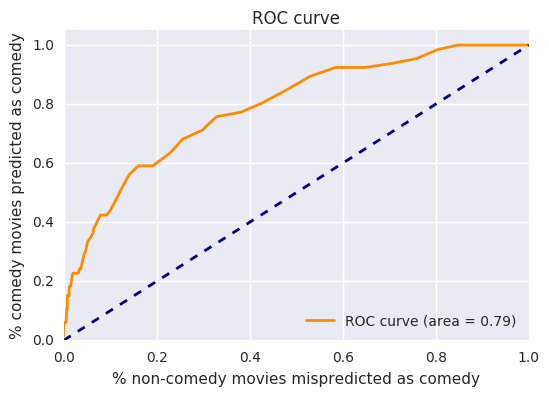

In [247]:
scores_better = [x[1] for x in predictions_cv_comedy_scores]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(is_comedy,scores_better)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % sklearn.metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('% non-comedy movies mispredicted as comedy')
plt.ylabel('% comedy movies predicted as comedy')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [250]:
importances = sorted(dict(zip(comedy_fits[1][0:20],best_comedy_fit.best_estimator_.feature_importances_)).items(), key = lambda x: -x[1])
importances
for i in range(20):
    print("1. %s (%0.3f)" %(importances[i][0],importances[i][1]))

1. guy (0.116)
1. really (0.077)
1. hey (0.074)
1. just (0.072)
1. ball (0.065)
1. married (0.061)
1. asshole (0.056)
1. piss (0.052)
1. dude (0.051)
1. wow (0.048)
1. ups (0.045)
1. jay (0.043)
1. awesome (0.038)
1. chick (0.036)
1. ooh (0.033)
1. cheat (0.031)
1. puke (0.029)
1. mime (0.027)
1. dana (0.023)
1. psychotic (0.022)


In [151]:
best_action_fit = action_fits[2][1]
n_features = len(best_action_fit.best_estimator_.feature_importances_)
importances = action_fits[0].best_estimator_.feature_importances_
ordered_indices = np.argsort(importances)[::-1] #[::-1] just reverses

predictions_cv_action = cross_val_predict(best_action_fit.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    is_action,
                                    cv=20, n_jobs=best_action_fit.n_jobs)

In [154]:
import sklearn
sklearn.metrics.confusion_matrix(is_action,predictions_cv_action)

array([[712,   9],
       [ 57,  49]])

In [174]:
predictions_cv_action[np.where(movies_df["title"].str.contains("Terminator"))[0]]

array([ True,  True], dtype=bool)

In [183]:
predictions_cv_action_scores = cross_val_predict(best_action_fit.best_estimator_,
                                    features[:,ordered_indices[0:n_features]],
                                    is_action,
                                    cv=20, n_jobs=best_action_fit.n_jobs,
                                                method = "predict_proba")



KeyboardInterrupt: 

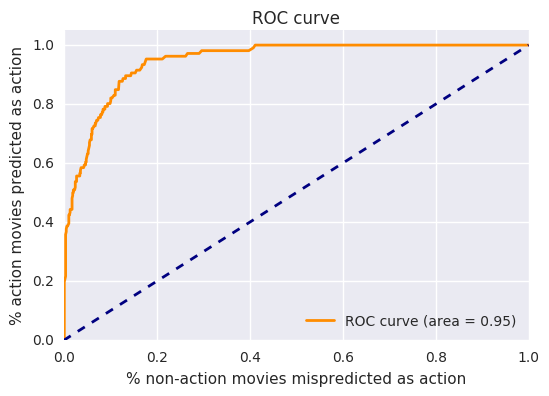

In [246]:
scores_better = [x[1] for x in predictions_cv_action_scores]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(is_action,scores_better)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % sklearn.metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('% non-action movies mispredicted as action')
plt.ylabel('% action movies predicted as action')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
importances = sorted(dict(zip(action_fits[1][0:50],best_comedy_.best_estimator_.feature_importances_)).items(), key = lambda x: -x[1])
importances
for i in range(25):
    print("1. %s (%0.3f)" %(importances[i][0],importances[i][1]))

In [150]:
action_fits[2][1].best_score_
#sorted(dict(zip(action_fits[1][0:50],action_fits[3][1].best_estimator_.coef_.tolist()[0])).items(), key = lambda x: -x[1])
#action_fits[1][0:50]


0.92019347037484889

In [200]:
importances = sorted(dict(zip(action_fits[1][0:50],action_fits[2][1].best_estimator_.feature_importances_)).items(), key = lambda x: -x[1])
importances
for i in range(25):
    print("1. %s (%0.3f)" %(importances[i][0],importances[i][1]))

1. weapon (0.076)
1. explodes (0.046)
1. aim (0.046)
1. crash (0.036)
1. fire (0.030)
1. bullet (0.030)
1. wall (0.030)
1. gun (0.027)
1. drop (0.026)
1. chopper (0.026)
1. oh (0.024)
1. steel (0.024)
1. rooftop (0.024)
1. trigger (0.024)
1. air (0.023)
1. fly (0.023)
1. punch (0.023)
1. slam (0.022)
1. building (0.021)
1. blast (0.021)
1. slide (0.021)
1. dive (0.020)
1. helicopter (0.019)
1. control (0.019)
1. scan (0.018)


Below is just some testing on the X2 factor:

In [188]:
x4_fit = elastic_forest(movies_df["X2"])

Time to fit: 147.014942
Time to fit: 32.715335


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

2.6552932262420654
Time to fit: 36.015357


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

3.1547577381134033
Time to fit: 39.457095


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

4.1008055210113525
Time to fit: 48.193764


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might wa

5.546707391738892


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [189]:
process_fit_object_pickling(x4_fit)
with open("saved_objects/test_x4_fit.pickle","wb") as handle:
    pickle.dump(x4_fit,handle)

In [194]:
with open("saved_objects/test_x4_fit.pickle","rb") as handle:
    test = pickle.load(handle)

/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.00777, std: 0.01223, params: {'alpha': 1, 'l1_ratio': 0.0},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 0.1},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 0.3},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 0.5},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 0.7},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 0.9},
 mean: -0.01075, std: 0.01186, params: {'alpha': 1, 'l1_ratio': 1.0},
 mean: 0.01713, std: 0.01716, params: {'alpha': 0.1, 'l1_ratio': 0.0},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 0.1},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 0.3},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 0.5},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 0.7},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 0.9},
 mean: -0.01075, std: 0.01186, params: {'alpha': 0.1, 'l1_ratio': 1.0},
 mean: 

In [109]:
#How to get importances/coefficients
#for the full random forest (this only works for the best estimator)
dict(zip(x4_fit[1],np.sort(x4_fit[0].best_estimator_.feature_importances_,)[::-1]))
#one of the random forests with fewer features
dict(zip(x4_fit[1][0:50],x4_fit[2][1].best_estimator_.feature_importances_))
#one of the elastic nets with fewer features
dict(zip(x4_fit[1][0:50],x4_fit[3][1].best_estimator_.coef_))

{'arm': -0.0,
 'ask': 2.4273075933105468e-06,
 'bitch': -0.0,
 'blood': -4.7081119163236433e-05,
 'body': -6.3883066128336488e-05,
 'box': 0.0,
 'broom': 0.0,
 'clothes': 0.0,
 'come': 1.7320106461579729e-05,
 'day': 0.0,
 'dead': -0.0,
 'denny': -0.00028346633159504619,
 'door': -0.0,
 'excuse': 0.0,
 'flesh': -0.0002981793977530888,
 'fuck': -0.00010193992493098029,
 'fucker': -4.4706060132273728e-05,
 'fuckin': -4.2015943882449404e-05,
 'gun': -1.5527972053474235e-05,
 'hand': -0.0,
 'hey': 0.0,
 'ho': 0.0,
 'hoo': 0.00065399276111242303,
 'human': -0.0,
 'int': 0.0,
 'lime': -0.00019985497363535955,
 'll': 0.0,
 'marry': 0.00073399178336144301,
 'mayhem': -0.0,
 'motherfucker': -0.0002674387456674509,
 'nod': 3.3657358817495898e-05,
 'oh': 0.0,
 'personal': 0.0,
 'potion': 0.0,
 'potter': 0.00012133057078376908,
 'pussy': -0.00054995799789198476,
 'say': 0.0,
 'scream': -0.00014539217320013359,
 'shit': -0.0,
 'sir': 1.3846686056723491e-06,
 'spell': 0.0008862087820058844,
 'tail':

In [127]:
x4_fit[3][0].best_score_

0.20173182885386404

In [6]:
movies_df.sort_values(by="X2")[["title","X2"]]

,title,X2
536,Natural Born Killers (1994),-0.075095
282,Fight Club (1999),-0.064130
298,From Dusk Till Dawn (1996),-0.060262
277,Fear and Loathing in Las Vegas (1998),-0.059811
267,Event Horizon (1997),-0.059577
763,Trainspotting (1996),-0.052934
108,"Big Lebowski, The (1998)",-0.052570
604,Pulp Fiction (1994),-0.051385
47,American Psycho (2000),-0.051318
624,Reservoir Dogs (1992),-0.050662


In [264]:
with open("saved_objects/X1_fit.pickle","rb") as handle:
    X1_fit = pickle.load(handle)

with open("saved_objects/X2_fit.pickle","rb") as handle:
    X2_fit = pickle.load(handle)

In [289]:
movies_df.sort_values(by="X2",ascending=True)[["title","X2"]]

,title,X2
536,Natural Born Killers (1994),-0.075095
282,Fight Club (1999),-0.064130
298,From Dusk Till Dawn (1996),-0.060262
277,Fear and Loathing in Las Vegas (1998),-0.059811
267,Event Horizon (1997),-0.059577
763,Trainspotting (1996),-0.052934
108,"Big Lebowski, The (1998)",-0.052570
604,Pulp Fiction (1994),-0.051385
47,American Psycho (2000),-0.051318
624,Reservoir Dogs (1992),-0.050662
